# Exercise X.01.1

In [77]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In this exercise we want to find the parameters of a SIR model using physics informed least square regression (LSR). We start by recreating the example given on slide 35 in lecture note 1.

The SIR model is given by
\begin{align*}
\frac{\partial S}{\partial t} &= -\beta\frac{SI}{N}, \\
\frac{\partial I}{\partial t} &= \beta\frac{SI}{N} - \gamma I, \\
\frac{\partial R}{\partial t} &= \gamma I, \\
\end{align*}

where S is the number of susceptible individuals, I is the number of infected individuals, and R is the number of recovered indiciduals. Here $\beta$ and $\gamma$ are the infection and recovery rates, which we wish to determine by using physics informed LSR.

In [78]:
# RHS function
def sir_model(t, y, beta, gamma):
    # Define the system of differential equations
    S, I, R = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

def sir_derivatives(S, I, R, t):
    # Estimate derivatives using forward stencil on datapoints.
    h = t[1]-t[0]

    dSdt = np.zeros_like(S)
    dIdt = np.zeros_like(S)
    dRdt = np.zeros_like(S)
    
    #Estimate inner derivatives using central stencil
    dSdt[1:-1] = (S[2:] - S[:-2])/(2*h)
    dIdt[1:-1] = (I[2:] - I[:-2])/(2*h)
    dRdt[1:-1] = (R[2:] - R[:-2])/(2*h)

    # Compute boundaties using forward and backward stencil
    dSdt[0] = (S[1]-S[0])/h
    dIdt[0] = (I[1]-I[0])/h
    dRdt[0] = (R[1]-R[0])/h

    dSdt[-1] = (S[-1]-S[-2])/h
    dIdt[-1] = (I[-1]-I[-2])/h
    dRdt[-1] = (R[-1]-R[-2])/h

    return dSdt, dIdt, dRdt

def sir_matrix(S, I, R, N=1):
    # Add extra dimension to make it easier to create the A matrix
    S = np.expand_dims(S, axis = 1)
    I = np.expand_dims(I, axis = 1)
    R = np.expand_dims(R, axis = 1)

    # Create the columns for each ODE
    A1 = np.concatenate([-S*I/N, np.zeros(S.shape)], axis = 1)
    A2 = np.concatenate([S*I/N, -I], axis = 1)
    A3 = np.concatenate([np.zeros(S.shape), I], axis = 1)


    A = np.concatenate([A1, A2, A3], axis = 0)
    return A

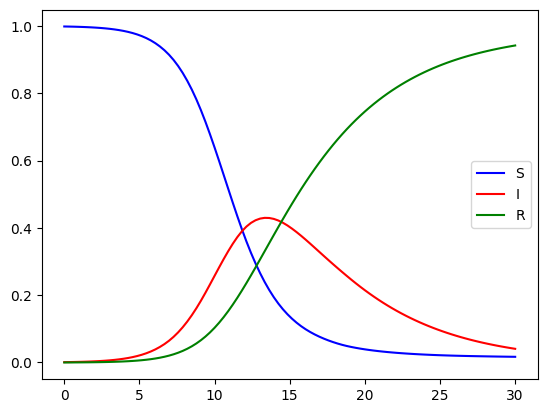

In [79]:
# Define the initial conditions and parameter values
y0 = [1-0.001, 0.001, 0] # [S, I, R]
beta = 0.8
gamma = 1./5.4
tspan = (0, 30) # Define the time span for the simulation
# Solve the system of differential equations using solve_ivp
tmeasurements = np.linspace(0, 30, 100)
sol = solve_ivp(lambda t, y: sir_model(t, y, beta, gamma), tspan, y0, t_eval=tmeasurements)


# Plot the results
plt.plot(sol.t, sol.y[0], "b", sol.t, sol.y[1], "r", sol.t, sol.y[2], "g")
plt.legend(["S", "I", "R"])
plt.show()

We now use the generated solution to estimate $\beta$ and $\gamma$ by solving
$$
\begin{bmatrix}
\frac{\partial S}{\partial t}\\
\frac{\partial I}{\partial t}\\
\frac{\partial R}{\partial t}\\
\end{bmatrix} =
\begin{bmatrix}
-\frac{SI}{N} & 0 \\
\frac{SI}{N} & - I \\
 0 &  I \\
\end{bmatrix}\cdot
\begin{bmatrix}
\beta\\
\gamma
\end{bmatrix}
$$

Note that in this case $N=1$.

In [80]:
S = sol.y[0]
I = sol.y[1]
R = sol.y[2]

dSdt, dIdt, dRdt = sir_derivatives(S, I, R, sol.t)

A = sir_matrix(S, I, R)
b = np.concatenate([dSdt, dIdt, dRdt])


params = np.linalg.inv(np.conj(A).T @ A) @ np.conj(A).T @ b

errors = params - [beta, gamma]

print(f"Estimated paramters: {params}")
print("Errors:", errors)

Estimated paramters: [0.79954364 0.18499402]
Errors: [-0.00045636 -0.00019116]


We now add the possibility of dying to the model. That is the model becomes
\begin{align*}
\frac{\partial S}{\partial t} &= -\beta\frac{SI}{N}, \\
\frac{\partial I}{\partial t} &= \beta\frac{SI}{N} - \gamma I - \kappa D, \\
\frac{\partial R}{\partial t} &= \gamma I, \\
\frac{\partial D}{\partial t} &= \kappa D, \\
\end{align*}
where D is the number of dead people.

In [84]:
# RHS function
def sird_model(t, y, beta, gamma, kappa):
    # Define the system of differential equations
    S, I, R, D = y
    dSdt = -beta * S * I
    dIdt = beta * S * I - gamma * I- kappa * I
    dRdt = gamma * I
    dDdt = kappa * I
    return [dSdt, dIdt, dRdt, dDdt]

def sird_derivatives(S, I, R, D, t):
    # Estimate derivatives using forward stencil on datapoints.
    h = t[1]-t[0]

    dSdt = np.zeros_like(S)
    dIdt = np.zeros_like(S)
    dRdt = np.zeros_like(S)
    dDdt = np.zeros_like(S)
    
    #Estimate inner derivatives using central stencil
    dSdt[1:-1] = (S[2:] - S[:-2])/(2*h)
    dIdt[1:-1] = (I[2:] - I[:-2])/(2*h)
    dRdt[1:-1] = (R[2:] - R[:-2])/(2*h)
    dDdt[1:-1] = (D[2:] - D[:-2])/(2*h)

    # Compute boundaties using forward and backward stencil
    dSdt[0] = (S[1]-S[0])/h
    dIdt[0] = (I[1]-I[0])/h
    dRdt[0] = (R[1]-R[0])/h
    dDdt[0] = (D[1]-D[0])/h

    dSdt[-1] = (S[-1]-S[-2])/h
    dIdt[-1] = (I[-1]-I[-2])/h
    dRdt[-1] = (R[-1]-R[-2])/h
    dDdt[-1] = (D[-1]-D[-2])/h

    return dSdt, dIdt, dRdt, dDdt

def sird_matrix(S, I, R, D, N=1):
    # Add extra dimension to make it easier to create the A matrix
    S = np.expand_dims(S, axis = 1)
    I = np.expand_dims(I, axis = 1)
    R = np.expand_dims(R, axis = 1)
    D = np.expand_dims(D, axis = 1)
    

    # Create the columns for each ODE
    A1 = np.concatenate([-S*I/N, np.zeros(S.shape), np.zeros(S.shape)], axis = 1)
    A2 = np.concatenate([S*I/N, -I, -I], axis = 1)
    A3 = np.concatenate([np.zeros(S.shape), I, np.zeros(S.shape)], axis = 1)
    A4 = np.concatenate([np.zeros(S.shape), np.zeros(S.shape), I], axis = 1)


    A = np.concatenate([A1, A2, A3, A4], axis = 0)
    return A

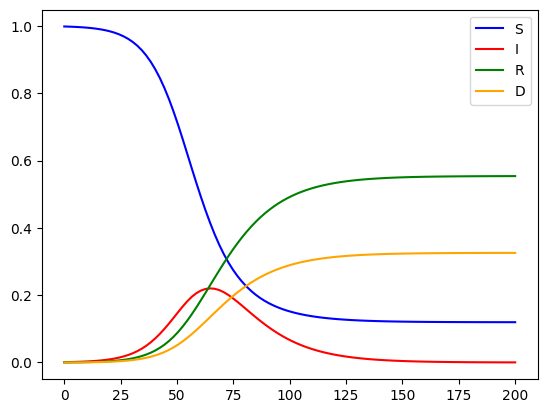

In [82]:
# Define the initial conditions and parameter values
y0 = [1-0.001, 0.001, 0, 0] # [S, I, R, D]

# Paramters for Covid-19 from Shaier, Raissi & Seshaiyer (2022) page 18.
beta = 0.191 
gamma = 0.05
kappa = 0.0294
tspan = (0, 200) # Define the time span for the simulation
# Solve the system of differential equations using solve_ivp
tmeasurements = np.linspace(0, 200, 100)
sol = solve_ivp(lambda t, y: sird_model(t, y, beta, gamma, kappa), tspan, y0, t_eval=tmeasurements)


# Plot the results
plt.plot(sol.t, sol.y[0], "b", sol.t, sol.y[1], "r", sol.t, sol.y[2], "g", sol.t, sol.y[3], "orange")
plt.legend(["S", "I", "R", "D"])
plt.show()

In [86]:
S = sol.y[0]
I = sol.y[1]
R = sol.y[2]
D = sol.y[3]

dSdt, dIdt, dRdt, dDdt = sird_derivatives(S, I, R, D, sol.t)

A = sird_matrix(S, I, R, D)
b = np.concatenate([dSdt, dIdt, dRdt, dDdt])


params = np.linalg.inv(np.conj(A).T @ A) @ np.conj(A).T @ b

errors = params - [beta, gamma, kappa]

print(f"Estimated paramters: {params}")
print("Errors:", errors)

Estimated paramters: [0.19118726 0.04992738 0.02934632]
Errors: [ 1.87261953e-04 -7.26249331e-05 -5.36793875e-05]
